In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# 创建示例数据

In [2]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [3]:
import sys
sys.path.insert(0,  '/home/was966/Research/mims-conceptor/')
from conceptor.tokenizer import CONCEPT_palette

In [21]:
def plot_feature_rankings2(dfa, dfb, sample_cmap, use_exvar_for_y =False):
    """
    Plots the rankings of features across three dataframes with their exvar values.
    
    Parameters:
    dfa, dfb, dfc (pd.DataFrame): Dataframes containing the features and their exvar values.
    cmap (dict): A dictionary mapping features to colors.
    """


    all_features = list(set(dfa.index) | set(dfb.index))

    # 使用Matplotlib的colormap生成鲜艳的颜色
    num_features = len(all_features)

    positions = {'a': 1, 'b': 2,}


    fig, ax = plt.subplots(figsize=(18, 15))
    
    # 对每个数据帧的特征按exvar值进行排序，获取排名
    sorted_indices_a = dfa['abs_shap'].sort_values(ascending=True).index
    sorted_indices_b = dfb['abs_shap'].sort_values(ascending=True).index


    top = 10
    top10_verlap = list(set(sorted_indices_a[-top:]) | set(sorted_indices_b[-top:]) )
    #top10_verlap = sorted_indices_b[-top:]
    #top10_verlap = dfb[dfb['exvar'] > 0.1].index
    
    for feature in all_features:

        feature_color = sample_cmap[feature]

        # 绘制圆点及其标准差阴影，Y位置由exvar值决定
        if use_exvar_for_y:
            a_exvar = dfa.loc[feature, 'abs_shap'] if feature in dfa.index else None
            b_exvar = dfb.loc[feature, 'abs_shap'] if feature in dfb.index else None

    
            if a_exvar is not None:
                ax.scatter(positions['a'], a_exvar, s=a_exvar * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['a'], a_exvar, s=(a_exvar + dfa.loc[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.2, edgecolor='none')
            if b_exvar is not None:
                ax.scatter(positions['b'], b_exvar, s=b_exvar * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['b'], b_exvar, s=(b_exvar + dfb.loc[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.2, edgecolor='none')

            # 绘制箭头
            if feature in top10_verlap:
                
                if a_exvar is not None and b_exvar is not None:
                    ax.annotate("", xy=(positions['b'], b_exvar), xytext=(positions['a'], a_exvar),
                                 arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5", color=feature_color, lw=1.5))

            vals = ax.get_yticks()
            ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
            ax.text(positions['b']+0.05, b_exvar, feature)
            
        else:
            # 获取在每个数据帧中的排名
            a_rank = np.where(sorted_indices_a == feature)[0][0] if feature in dfa.index else None
            b_rank = np.where(sorted_indices_b == feature)[0][0] if feature in dfb.index else None

            
            
            # 绘制圆点及其标准差阴影
            if a_rank is not None:
                ax.scatter(positions['a'], a_rank, s=dfa.at[feature, 'abs_shap'] * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['a'], a_rank, s=(dfa.at[feature, 'abs_shap'] + dfa.at[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.4, edgecolor='none')
            if b_rank is not None:
                ax.scatter(positions['b'], b_rank, s=dfb.at[feature, 'abs_shap'] * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['b'], b_rank, s=(dfb.at[feature, 'abs_shap'] + dfb.at[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.4, edgecolor='none')

            # 绘制箭头
            if feature in top10_verlap:
                if a_rank is not None and b_rank is not None:

                    #ac = 'red' if a_rank > b_rank else 'blue'
                    ac = feature_color
                    ax.annotate("", xy=(positions['b'], b_rank), xytext=(positions['a'], a_rank),
                                 arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5", color=ac, lw=1.))

            plt.yticks(np.arange(dfa.shape[0]), sorted_indices_a)

            
       
    
    ax.tick_params(axis='both', which='major', right = False, top=True, bottom=False, direction = 'out',reset = True)
    plt.xticks([1, 2], ['Zero-shot\n(Pretraining only)', 'Cohort\nFinetuning'])
    plt.tick_params(axis='x', labeltop=True, labelbottom=False)
    
    #plt.title('Feature Ranking with Exvar and Std')
    plt.xlabel('IMVigor210 cohort')
    if not use_exvar_for_y:
        plt.ylabel('Concepts Ranking')
    else:
        plt.ylabel('Feature explained variance to response')
    plt.grid(True, linestyle='--', color='#dddddd')


    if not use_exvar_for_y:
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        # 如果sorted_indices_c的长度与ax.get_yticks()返回的刻度数相同，则可以直接设置
        ax2.set_yticks(ax.get_yticks())
        # 如果sorted_indices_c是字符串列表，包含特征名称，可以直接赋值
        ax2.set_yticklabels(sorted_indices_b)

        
        
    # Legend for exvar sizes (as percentages)
    # Create custom legend
    for i, size in enumerate(np.linspace(0.1, 0.5, 5)):
        ax.scatter([], [], s=size * 1000, color='black', alpha=0.3, edgecolor='grey', label=f'{size * 100:.0f}%')

    ax.legend(title='Explained Var.', bbox_to_anchor=(1.4, 1), loc='upper left', borderaxespad=0., fancybox=True)
    fig.tight_layout()    
    return fig

def plot_feature_rankings(dfa, dfb, dfc, sample_cmap, use_exvar_for_y =False):
    """
    Plots the rankings of features across three dataframes with their exvar values.
    
    Parameters:
    dfa, dfb, dfc (pd.DataFrame): Dataframes containing the features and their exvar values.
    cmap (dict): A dictionary mapping features to colors.
    """


    all_features = list(set(dfa.index) | set(dfb.index) | set(dfc.index))

    # 使用Matplotlib的colormap生成鲜艳的颜色
    num_features = len(all_features)

    positions = {'a': 1, 'b': 2, 'c': 3}


    fig, ax = plt.subplots(figsize=(18, 15))
    
    # 对每个数据帧的特征按exvar值进行排序，获取排名
    sorted_indices_a = dfa['abs_shap'].sort_values(ascending=True).index
    sorted_indices_b = dfb['abs_shap'].sort_values(ascending=True).index
    sorted_indices_c = dfc['abs_shap'].sort_values(ascending=True).index

    top = 10
    
    top10_verlap = list(set(sorted_indices_a[-top:]) | set(sorted_indices_b[-top:]) | set(sorted_indices_c[-top:]))
    #top10_verlap = sorted_indices_c[-top:]
    #top10_verlap = dfc[dfc['exvar'] > 0.1].index
    
    for feature in all_features:

        feature_color = sample_cmap[feature]

        # 绘制圆点及其标准差阴影，Y位置由exvar值决定
        if use_exvar_for_y:
            a_exvar = dfa.loc[feature, 'abs_shap'] if feature in dfa.index else None
            b_exvar = dfb.loc[feature, 'abs_shap'] if feature in dfb.index else None
            c_exvar = dfc.loc[feature, 'abs_shap'] if feature in dfc.index else None
    
            if a_exvar is not None:
                ax.scatter(positions['a'], a_exvar, s=a_exvar * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['a'], a_exvar, s=(a_exvar + dfa.loc[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.2, edgecolor='none')
            if b_exvar is not None:
                ax.scatter(positions['b'], b_exvar, s=b_exvar * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['b'], b_exvar, s=(b_exvar + dfb.loc[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.2, edgecolor='none')
            if c_exvar is not None:
                ax.scatter(positions['c'], c_exvar, s=c_exvar * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['c'], c_exvar, s=(c_exvar + dfc.loc[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.2, edgecolor='none')
        
            # 绘制箭头
            if feature in top10_verlap:
                
                if a_exvar is not None and b_exvar is not None:
                    ax.annotate("", xy=(positions['b'], b_exvar), xytext=(positions['a'], a_exvar),
                                 arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5", color=feature_color, lw=1.5))
                if b_exvar is not None and c_exvar is not None:
                    ax.annotate("", xy=(positions['c'], c_exvar), xytext=(positions['b'], b_exvar),
                                 arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5", color=feature_color, lw=1.5))
        
            vals = ax.get_yticks()
            ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
            ax.text(positions['c']+0.1, c_exvar, feature)
            
        else:
            # 获取在每个数据帧中的排名
            a_rank = np.where(sorted_indices_a == feature)[0][0] if feature in dfa.index else None
            b_rank = np.where(sorted_indices_b == feature)[0][0] if feature in dfb.index else None
            c_rank = np.where(sorted_indices_c == feature)[0][0] if feature in dfc.index else None

            
            # 绘制圆点及其标准差阴影
            if a_rank is not None:
                ax.scatter(positions['a'], a_rank, s=dfa.at[feature, 'abs_shap'] * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['a'], a_rank, s=(dfa.at[feature, 'abs_shap'] + dfa.at[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.4, edgecolor='none')
            if b_rank is not None:
                ax.scatter(positions['b'], b_rank, s=dfb.at[feature, 'abs_shap'] * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['b'], b_rank, s=(dfb.at[feature, 'abs_shap'] + dfb.at[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.4, edgecolor='none')
            if c_rank is not None:
                ax.scatter(positions['c'], c_rank, s=dfc.at[feature, 'abs_shap'] * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['c'], c_rank, s=(dfc.at[feature, 'abs_shap'] + dfc.at[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.4, edgecolor='none')

            # 绘制箭头
            if feature in top10_verlap:
                if a_rank is not None and b_rank is not None:

                    #ac = 'red' if a_rank > b_rank else 'blue'
                    ac = feature_color
                    ax.annotate("", xy=(positions['b'], b_rank), xytext=(positions['a'], a_rank),
                                 arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5", color=ac, lw=1.))
                    
                if b_rank is not None and c_rank is not None:
                    #ac = 'red' if b_rank > c_rank else 'blue'
                    ac = feature_color
                    ax.annotate("", xy=(positions['c'], c_rank), xytext=(positions['b'], b_rank),
                                 arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5", color=ac, lw=1.))
                    

            plt.yticks(np.arange(dfa.shape[0]), sorted_indices_a)


    ax.tick_params(axis='both', which='major', right = False, top=True, bottom=False, direction = 'out',reset = True)

    plt.xticks([1, 2, 3], ['Zero-shot\n(Pretraining only)', 'Partial\nFinetuning', 'Full\nFinetuning'])
    plt.tick_params(axis='x', labeltop=True, labelbottom=False)
    
    #plt.title('Feature Ranking with Exvar and Std')
    plt.xlabel('IMVigor210 cohort')
    if not use_exvar_for_y:
        plt.ylabel('Concepts Ranking')
    else:
        plt.ylabel('Feature explained variance to response')
    plt.grid(True, linestyle='--', color='#dddddd')



    if not use_exvar_for_y:
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        # 如果sorted_indices_c的长度与ax.get_yticks()返回的刻度数相同，则可以直接设置
        ax2.set_yticks(ax.get_yticks())
        # 如果sorted_indices_c是字符串列表，包含特征名称，可以直接赋值
        ax2.set_yticklabels(sorted_indices_c)

    
    # Legend for exvar sizes (as percentages)
    # Create custom legend
    for i, size in enumerate(np.linspace(0.1, 0.5, 5)):
        ax.scatter([], [], s=size * 1000, color='black', alpha=0.3, edgecolor='grey', label=f'{size * 100:.0f}%')

    ax.legend(title='Explained Var.', bbox_to_anchor=(1.4, 1), loc='upper left', borderaxespad=0., fancybox=True)
    fig.tight_layout()    
    
    return fig

In [22]:
#!pip install numpy==1.24.3

In [31]:
df1 =pd.read_csv('./LFT/shap_lft_r.csv', index_col=0)
df2 =pd.read_csv('./FFT/shap_fft_r.csv', index_col=0)

In [32]:
dfa = df1.abs().mean().to_frame('abs_shap')
dfa = dfa.join(df1.abs().std().to_frame('std'))

In [33]:
dfb = df2.abs().mean().to_frame('abs_shap')
dfb = dfb.join(df2.abs().std().to_frame('std'))

In [34]:
dfb.shape, dfa.shape

((45, 2), (45, 2))

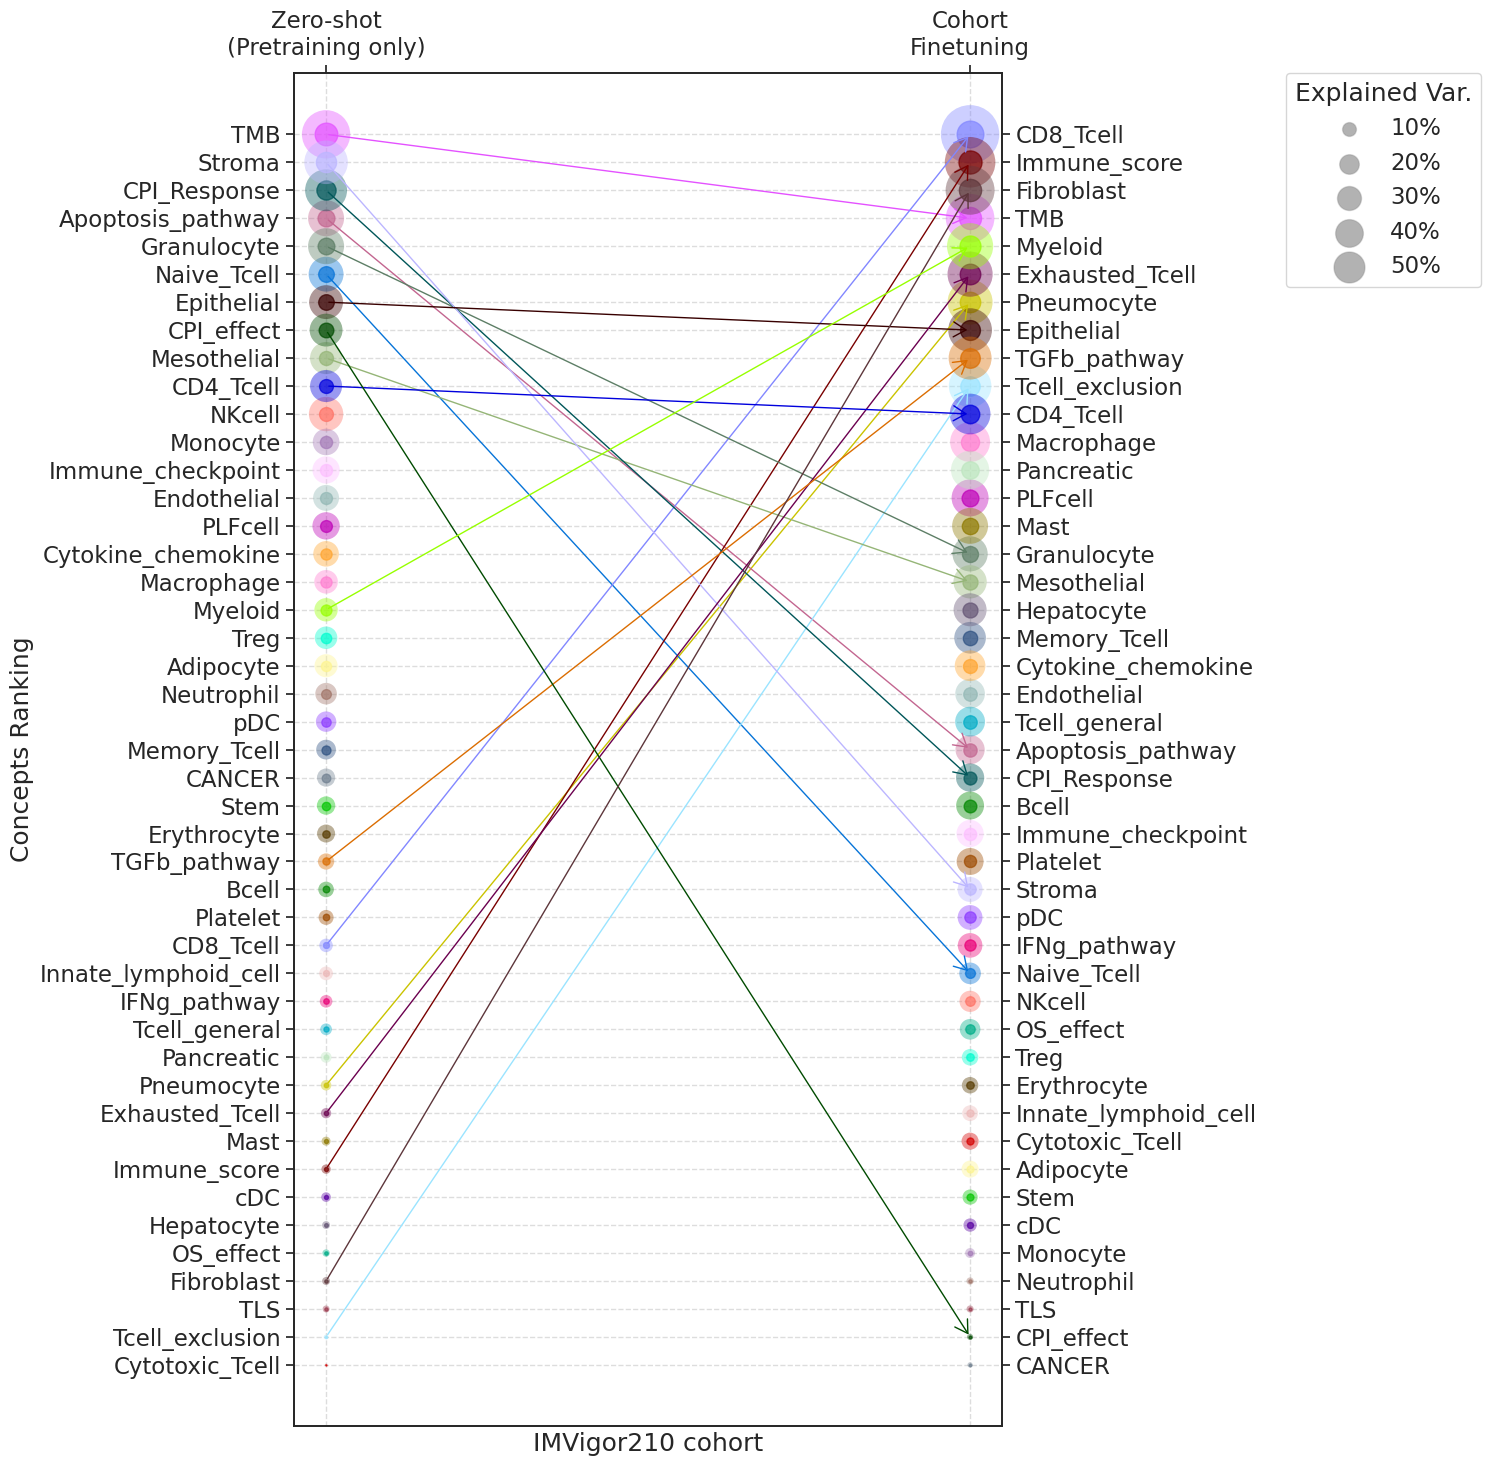

In [35]:
fig = plot_feature_rankings2(dfa, dfb, CONCEPT_palette,  use_exvar_for_y = False)
fig.savefig('./results/col2_y_var.pdf',bbox_inches  = 'tight')

/tmp/ipykernel_1482/135445924.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


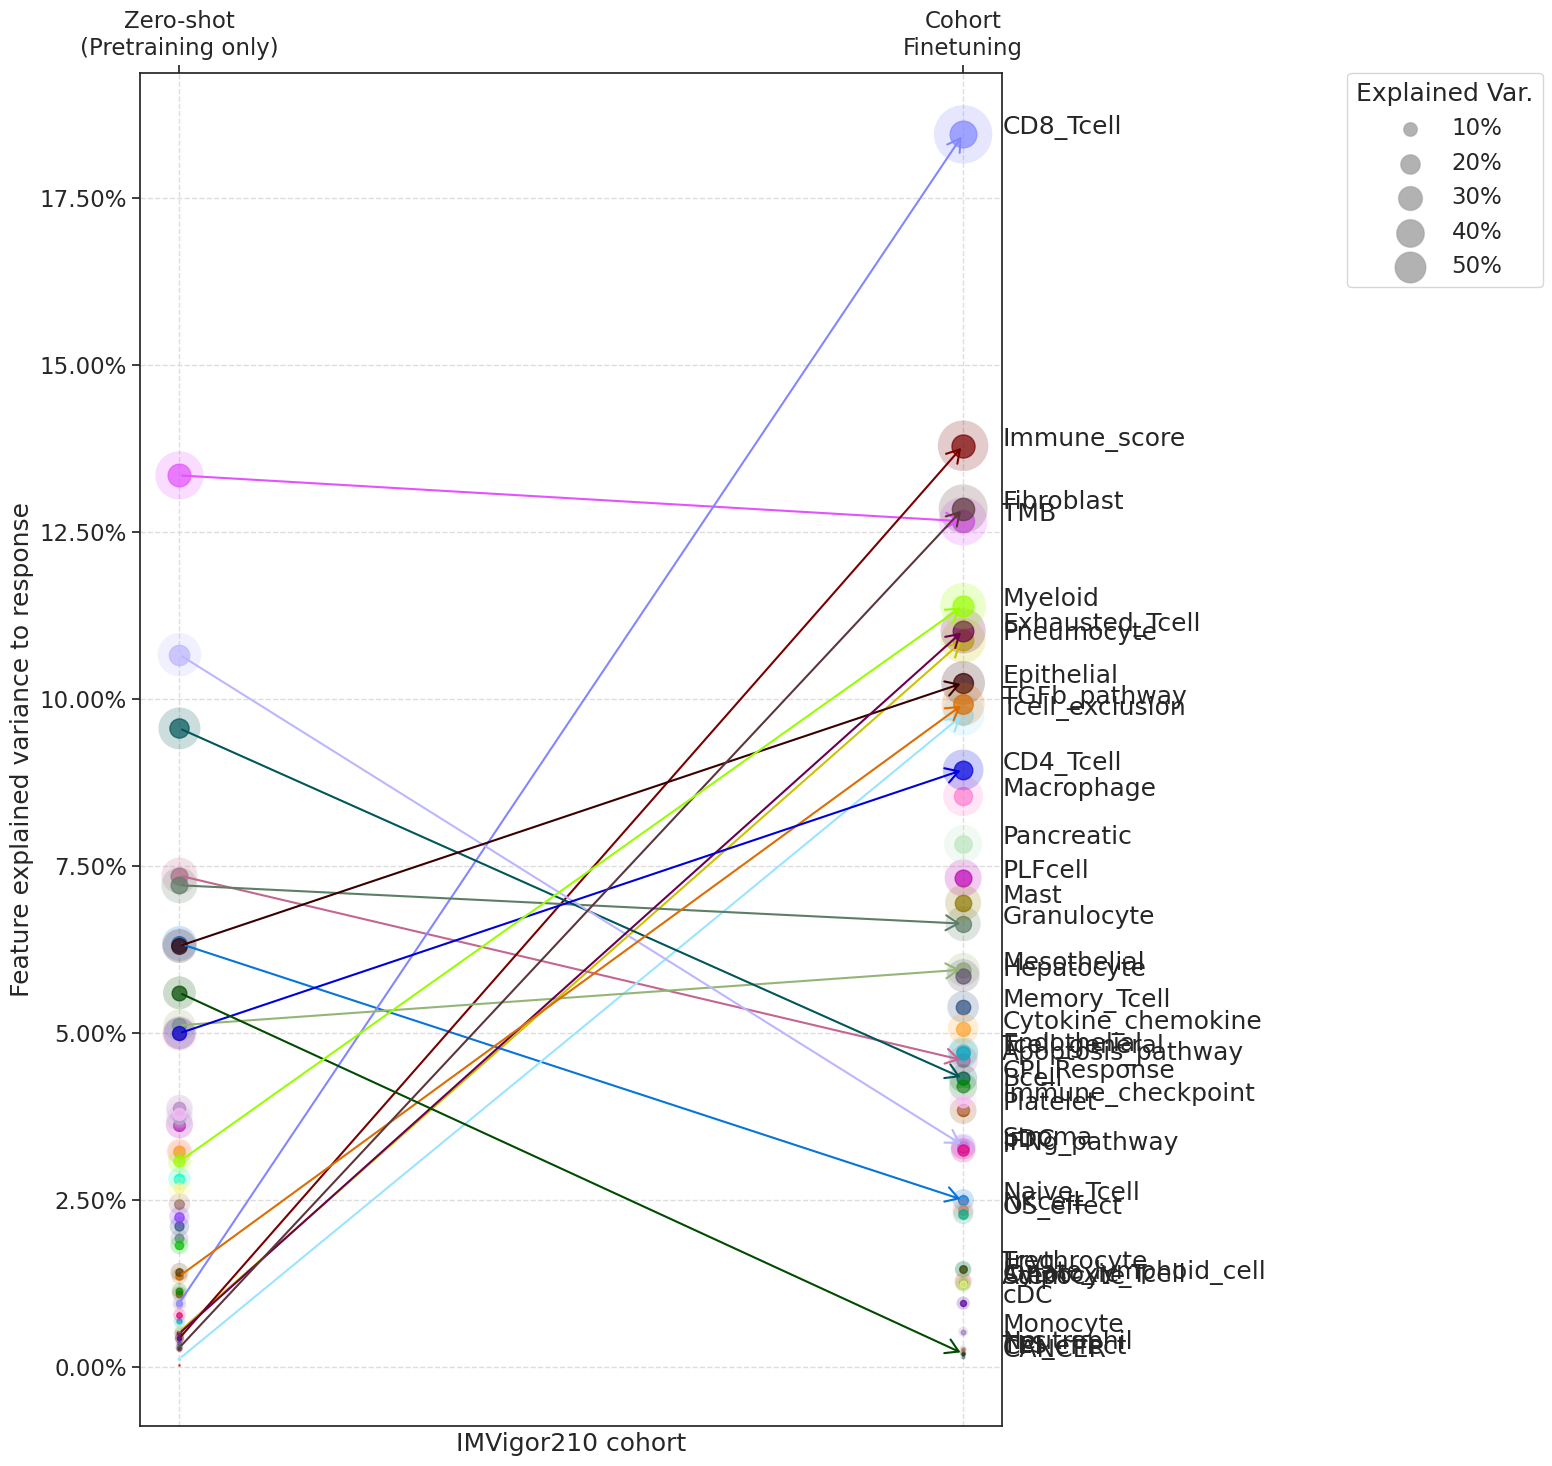

In [36]:
fig = plot_feature_rankings2(dfa, dfb, CONCEPT_palette,  use_exvar_for_y = True)
fig.savefig('./results/col2_y_rank.pdf',bbox_inches  = 'tight')

In [37]:
# Creating a list of dictionaries based on the given pairings and descriptions
pairings_list = [
    {'bio': 'Cytotoxic activity', 
     'pair': ['CD8_Tcell', 'Cytotoxic_Tcell'],
     'desc': 'CD8+ T cells are a primary type of cytotoxic T cells, essential for killing infected or cancerous cells, reflecting their direct cytotoxic activity.'},

    {'bio': 'Immune regulation', 
     'pair': ['CD4_Tcell', 'Cytokine_chemokine'],
     'desc': 'CD4+ T cells regulate immune responses through cytokine secretion, influencing other immune cells and mediating immune regulation.'},

    {'bio': 'Immune exhaustion and defense', 
     'pair': ['Exhausted_Tcell', 'NKcell'],
     'desc': 'Exhausted T cells show reduced function in chronic infections or cancer, while NK cells are key in early defense, highlighting the dynamics of immune surveillance and exhaustion.'},

    {'bio': 'Cell-mediated cytotoxicity', 
     'pair': ['Cytotoxic_Tcell', 'NKcell'],
     'desc': 'Both NK cells and cytotoxic T cells are involved in direct cell-mediated cytotoxicity, crucial for eliminating infected or tumor cells.'},

    {'bio': 'Immune communication and inflammation', 
     'pair': ['Macrophage', 'Cytokine_chemokine'],
     'desc': 'Macrophages play a central role in phagocytosis and immune modulation, communicating with other cells via cytokines, and are pivotal in inflammatory responses.'}
]

In [38]:
df1 = pd.read_csv('./LFT/DATA0_BLCA:IMVigor210.csv', index_col=0)
df2 = pd.read_csv('./FFT/DATA0_BLCA:IMVigor210.csv', index_col=0)
modes = ['Zero-shot\n(Pretraining only)',  'Full\nFinetuning']

In [39]:
hue = 'response_label'
hue_order = ['NR', 'R']

cm = sns.palettes.color_palette('tab10', 4)
palette = {'R':cm[1], 'NR':cm[0]}


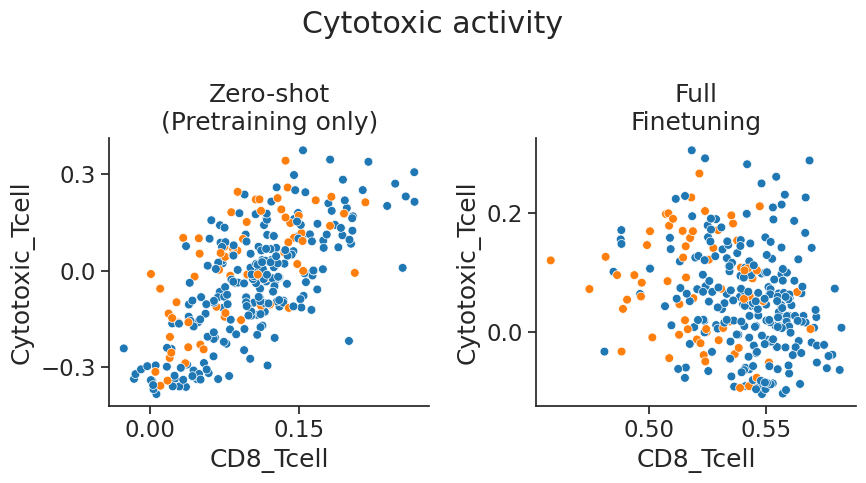

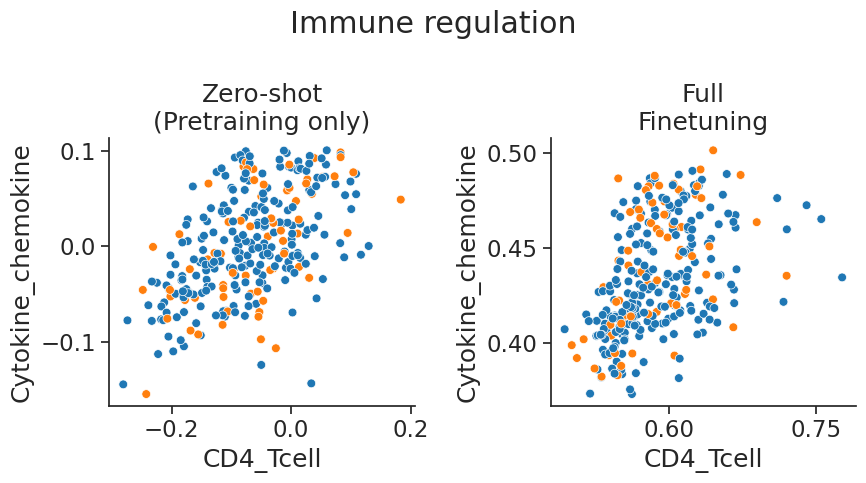

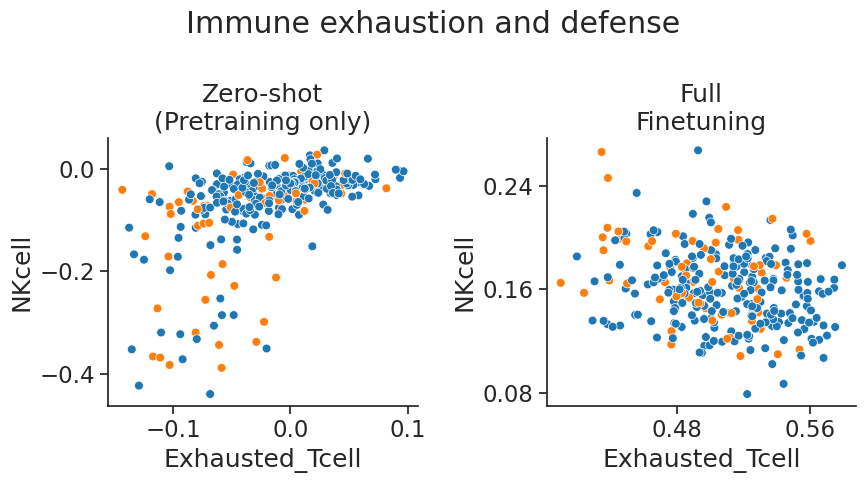

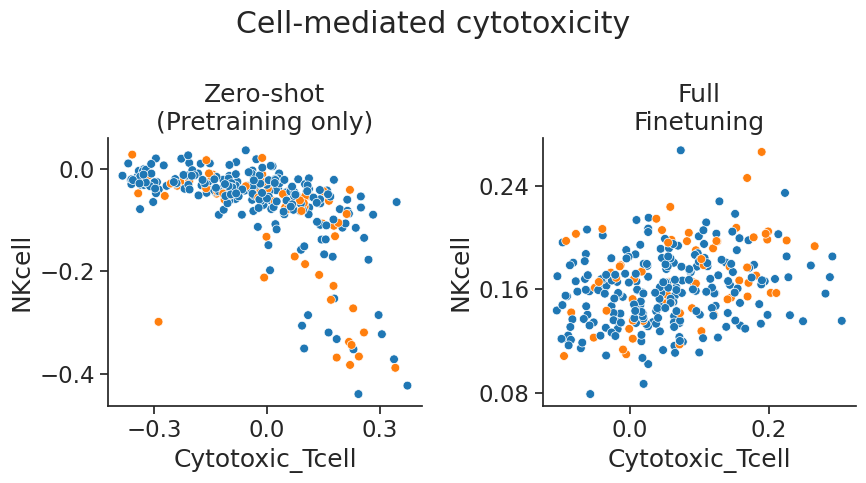

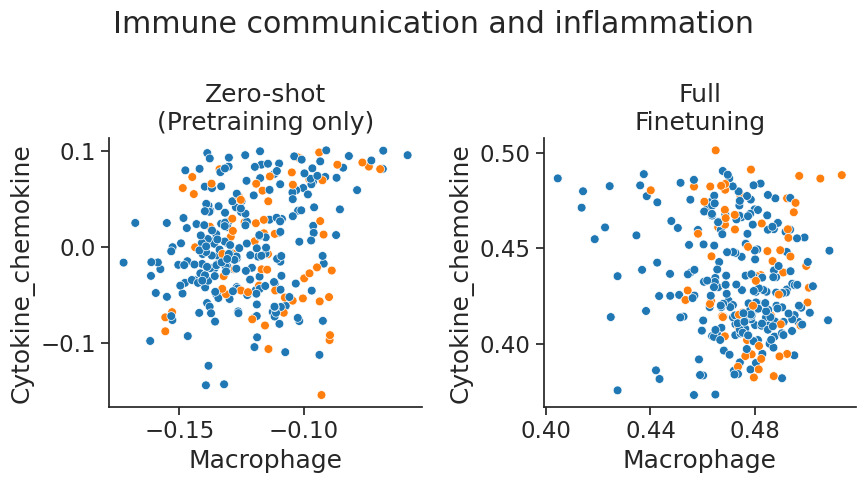

In [48]:
from matplotlib.ticker import MaxNLocator

for info in pairings_list:

    fig, axes = plt.subplots(figsize=(9,5), ncols=2)
    
    for df, mode, ax in zip([df1, df2], modes, axes):

    
        dfsp = df[info['pair']].join(df[hue])
        x,y = info['pair']
        sns.scatterplot(data=dfsp, x = x,y=y, hue = hue, hue_order = hue_order, ax=ax, palette = palette,
                        legend=False, s = 40, alpha = 1)
        ax.set_title(mode)
        fig.tight_layout() 
        ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3)) # 这里的'10'是您想要的刻度数量
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3)) # 这里的'10'是您想要的刻度数量
        ax.spines[['right', 'top']].set_visible(False)
    
    fig.suptitle(info['bio'])
    
    fig.tight_layout()

    fig.savefig('./results/pair_%s.pdf' % info['bio'], bbox_inches ='tight')
    fig.savefig('./results/pair_jpg_%s.jpg' % info['bio'], bbox_inches ='tight', dpi = 200)

In [ ]:
#dfc.exvar.sort_values()

/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:8.066e-02 U_stat=8.911e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.086e-13 U_stat=1.228e+04


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:2.806e-01 U_stat=7.146e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:8.987e-01 U_stat=7.900e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:2.675e-03 U_stat=9.695e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:6.025e-04 U_stat=9.962e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:4.655e-02 U_stat=6.577e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:4.852e-02 U_stat=6.588e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 17.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:8.901e-04 U_stat=9.895e+03


/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 19.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 20.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:3.653e-03 U_stat=6.005e+03


/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 20.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 24.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 24.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 24.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipy

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:7.269e-04 U_stat=5.710e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:3.228e-02 U_stat=6.483e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.815e-01 U_stat=7.835e+03


/tmp/ipykernel_1482/3882861180.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NR vs. R: Mann-Whitney-Wilcoxon test two-sided, P_val:9.944e-02 U_stat=6.791e+03


/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 24.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


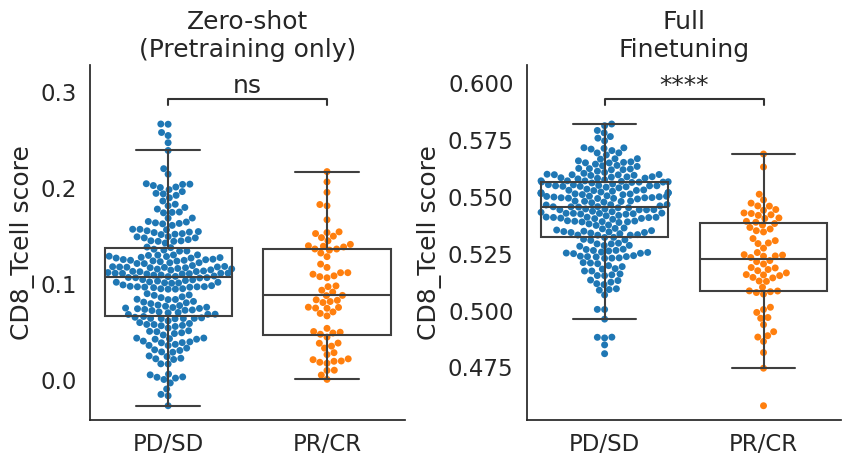

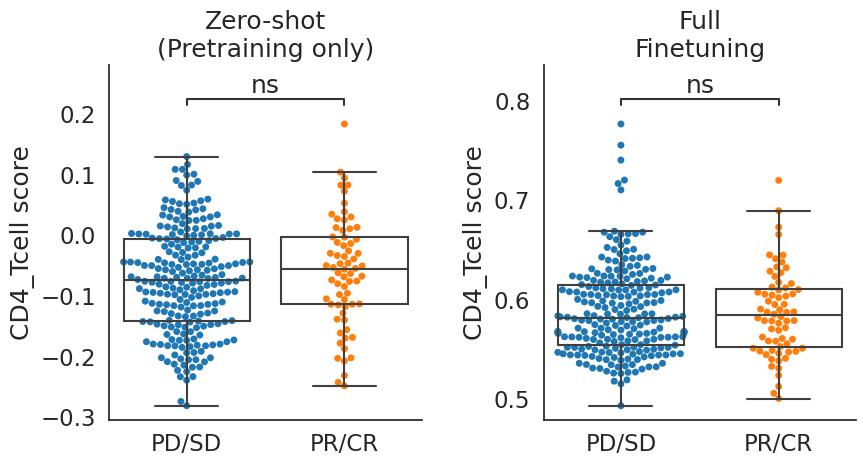

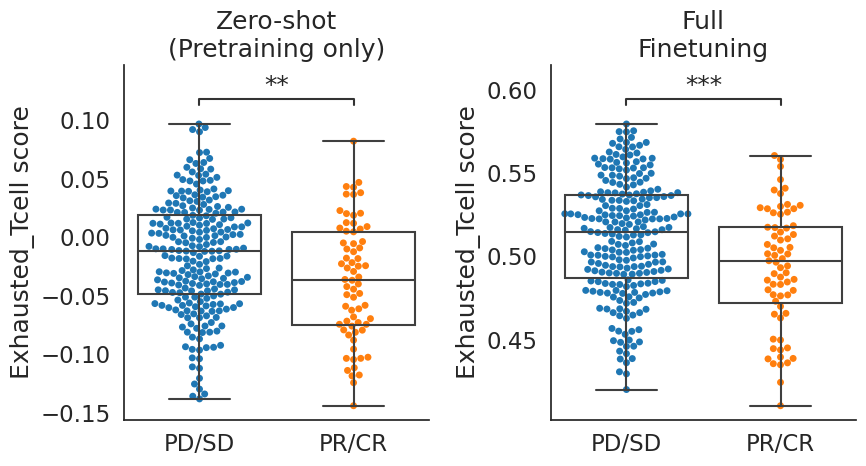

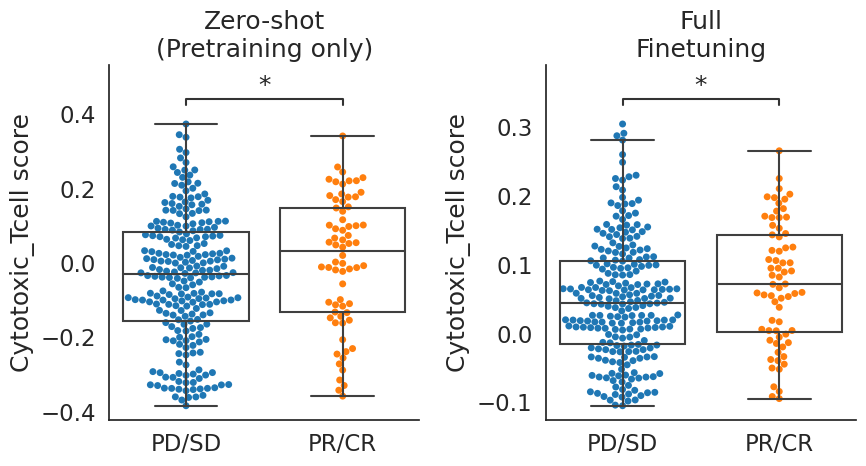

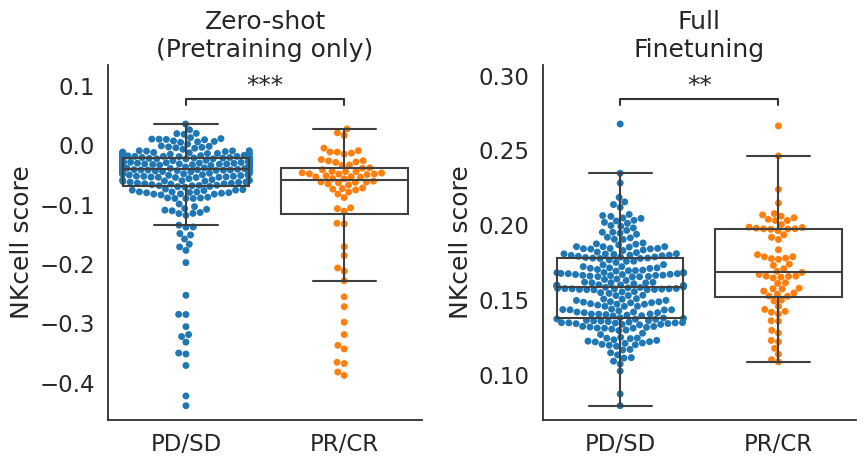

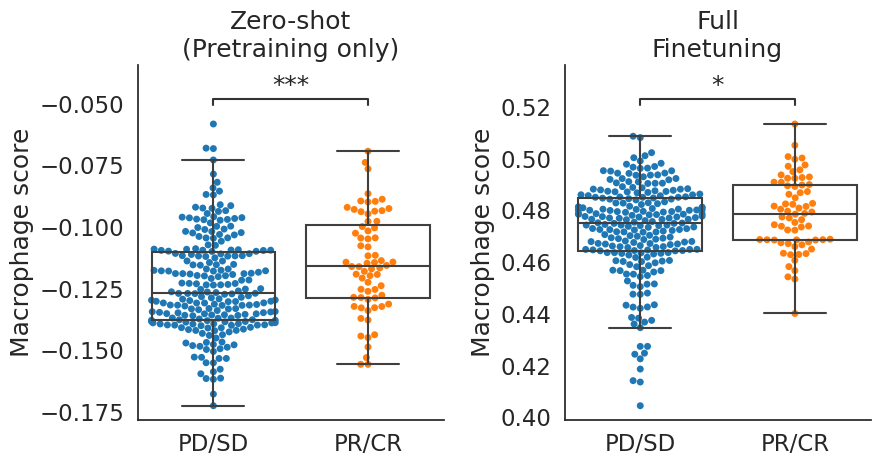

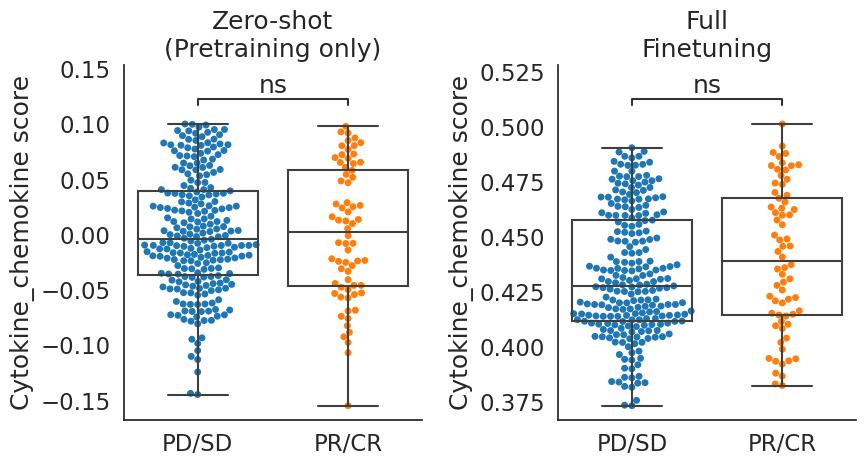

In [47]:
feature_list = ['CD8_Tcell', 'CD4_Tcell', 'Exhausted_Tcell', 
                'Cytotoxic_Tcell', 'NKcell', 'Macrophage', 'Cytokine_chemokine']

from matplotlib.ticker import MaxNLocator
from itertools import chain
from statannotations.Annotator import Annotator

box_pairs = [('NR', 'R')]
x = 'response_label'
order = ['NR', 'R']

for feature in feature_list:

    fig, axes = plt.subplots(figsize=(9,5), ncols=2)
    
    for df, mode, ax in zip([df1, df2,], modes, axes):

        dfbp = df[[feature]].join(df[hue])

        y = feature
    
        sns.boxplot(data = dfbp, x = x, y = y, fliersize = 0, width = .8,
                    ax=ax, order = order, palette=palette, boxprops={'facecolor':'None'})
        sns.swarmplot(data = dfbp, x = x, y = y,  ax=ax, order = order, palette = palette, zorder=0.5,)
        
        annotator = Annotator(ax, pairs=box_pairs, data=dfbp, x=x, y=y, order=order)
        annotator.configure(test='Mann-Whitney', text_format='star',  loc='inside', comparisons_correction = None,)
        annotator.apply_and_annotate()
        
        ax.set_xticklabels(['PD/SD', 'PR/CR'])
        
        ax.set_xlabel('')
        ax.set_ylabel('%s score' % feature)
    
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_title(mode)

    fig.tight_layout()

    fig.savefig('./results/feature_%s.pdf' % feature, bbox_inches ='tight')
    fig.savefig('./results/feature_jpg_%s.jpg' % feature, bbox_inches ='tight', dpi = 200)
    